# CRISP - DM Method

+ Business understanding – What does the business need?
+ Data understanding – What data do we have / need? Is it clean?
+ Data preparation – How do we organize the data for modeling?
+ Modeling – What modeling techniques should we apply?
+ Evaluation – Which model best meets the business objectives?
+ Deployment – How do stakeholders access the results?

# 1. Business understanding

#### Geschäftsführung bzw. Disposition des Unternehmens 

- Darstellung allgemeiner Erkenntnisse aus den Daten <br>
&rarr; Um E-Scooter-Geschäftsfeld besser zu durchdringen und um Rückschlüsse für die eigenen betrieblichen Handlungsbereiche aus den Daten zu ziehen



#### Abteilungsleiter

- Analysen sollen somit das operative Geschäft des Dispositionsleiters unterstützen <br>
&rarr; Wiederkehrende „Muster“ in den Daten sind dabei von besonderem Interesse

# 2. Data Understanding

In [3]:
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import plotly.express as px
import numpy as np

In [4]:
df = pd.read_parquet("escooter_history_2022.parquet")

ImportError: Unable to find a usable engine; tried using: 'pyarrow', 'fastparquet'.
A suitable version of pyarrow or fastparquet is required for parquet support.
Trying to import the above resulted in these errors:
 - Missing optional dependency 'pyarrow'. pyarrow is required for parquet support. Use pip or conda to install pyarrow.
 - Missing optional dependency 'fastparquet'. fastparquet is required for parquet support. Use pip or conda to install fastparquet.

# 3. Data Preperation

In [ ]:
# Temperaturspitzen entfernen
df = df[df.temp <75]

# Rechtschreibfehler korrigiert
df.replace({"weather":{"heacy rain or thunderstorm or snow or ice pallets":"heavy rain or thunderstorm or snow or ice pallets"}}, inplace=True)

# Wochentag einfügen
df["weekday"] = df["datetime"].dt.day_name()

# Umwandeln der verschiedenen Bool-Werte in 1 0 für späteres ML-Modell
df.registered_customer = df.registered_customer.astype(int)
df.holiday = df.holiday.astype(int)
df.workingday = df.workingday.astype(int)

# Quartal einfügen
df["quarter"] = df.datetime.dt.quarter

# Jahreszeit einfügen 
condlist = [(((df.datetime >= "2020-03-21") & (df.datetime <= "2020-06-20")) | ((df.datetime >= "2021-03-21") & (df.datetime <= "2021-06-20"))), 
            (((df.datetime >= "2020-06-21") & (df.datetime <= "2020-09-22")) | ((df.datetime >= "2021-06-21") & (df.datetime <= "2021-09-22"))), 
            (((df.datetime >= "2020-09-23") & (df.datetime <= "2020-12-20")) | ((df.datetime >= "2021-09-23") & (df.datetime <= "2021-12-20")))] 

choicelist = ["Frühling", "Sommer", "Herbst"]

df["season"] = np.select(condlist, choicelist, default="Winter")



Spalte mit daytype generieren

In [ ]:
# Herausfiltern der Übergangszeiten in denen falsche Einträge bei holiday und workingday sind
df_weekend = df[(df.datetime.dt.hour>1)&(df.datetime.dt.hour <24)]

# Basierend auf den Spaltenwerten von holiday und workingday Tagestypen auswählen und in neue Spalte daytype schreiben
conditions= [df_weekend.holiday ==1, df_weekend.workingday==1, df_weekend.holiday == df_weekend.workingday]
choices = ["holiday","workingday", "weekend"]
df_weekend["daytype"] = np.select(conditions, choices)
df_weekend["date"] = df_weekend.datetime.dt.date
# neue Spalte date im Hauptdataframe erzeugen
df["date"] = df.datetime.dt.date
df_weekend = df_weekend.groupby([df_weekend.date, df_weekend.daytype], as_index=False)["datetime"].count().drop(columns="datetime")
# An allen Datensätzen an Date datetype mergen
df = df.merge(df_weekend, left_on="date", right_on="date")

In [ ]:
# Hinzufügen weiterer Spalten zur einfacheren Gruppierung
df["day"] = df.datetime.dt.day
df["hour"] = df.datetime.dt.hour
df['ym-date'] = df.datetime.dt.strftime('%Y-%m')

# 4. Modeling

In [ ]:
from scipy.stats import pearsonr, spearmanr

##### Spielt an Feiertagen mit Windgeschwindigkeit > 35 die Temperatur noch eine Rolle für die Ausleihzahlen der nicht registrierten Usern?

#### Ansatz 1: 
- Es werden nur Ausleihen berücksichtigt, bei denen beim Start der Ausleihe die Windgeschwindigkeit > 35 war (andere Ausleihen an diesem Tag werden nicht berücksichtigt)

In [ ]:
df_slice = df[(df.holiday == 1) & (df.windspeed > 35) & (df.registered_customer == 0)]
df_slice.shape

(191, 12)

In [ ]:
df_temp_rentals = df_slice.groupby("temp")[["datetime"]].count().reset_index().rename({"datetime":"rentals"}, axis=1)
df_temp_rentals

,temp,rentals
0,13.12,38
1,13.94,78
2,15.58,57
3,24.60,18


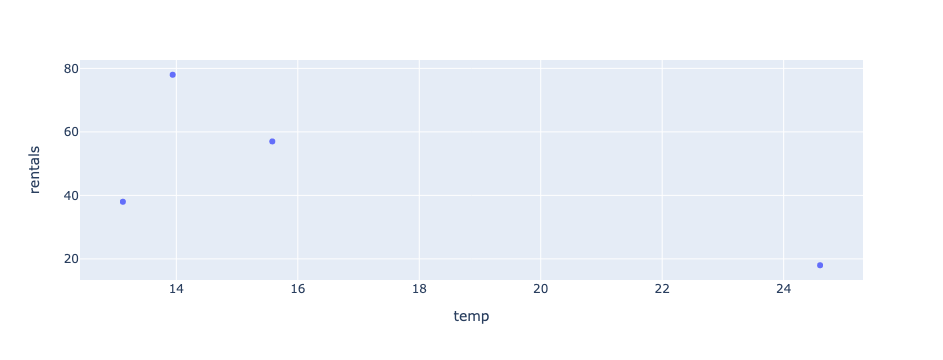

In [ ]:
px.scatter(df_temp_rentals, x="temp", y="rentals")

Spearman evtl. passender, da nichts über die Verteilung der Temperatur bekannt ist, bzw. die Art (linear/...) des möglichen Zusammenhangs

In [ ]:
pearsonr(df_temp_rentals["temp"], df_temp_rentals["rentals"])

(-0.7204756727342659, 0.27952432726573406)

In [ ]:
spearmanr(df_temp_rentals["temp"], df_temp_rentals["rentals"])

SpearmanrResult(correlation=-0.39999999999999997, pvalue=0.6)

#### Ansatz 2: 
- Es werden alle Ausleihen berücksichtigt, bei denen die Windgeschwindigkeit mind. ein mal an diesesm Tag > 35 war

In [ ]:
df_slice = df[(df.holiday == 1) & (df.registered_customer == 0)]

In [ ]:
dates_above_35 = df_slice.groupby(df_slice.datetime.dt.date).max().query("windspeed > 35")[["datetime"]]

In [ ]:
df_slice_full = df_slice[df_slice.datetime.dt.date.isin(dates_above_35.datetime.dt.date)]
df_slice_full.shape

(2377, 12)

In [ ]:
df_temp_rentals = df_slice_full.groupby("temp").agg({"datetime":"count"}).reset_index().rename({"datetime":"rentals"}, axis=1)
df_temp_rentals

,temp,rentals
0,9.02,6
1,10.66,14
2,11.48,10
3,12.30,44
4,13.12,151
5,13.94,251
6,14.76,154
7,15.58,287
8,22.96,9
9,24.60,18


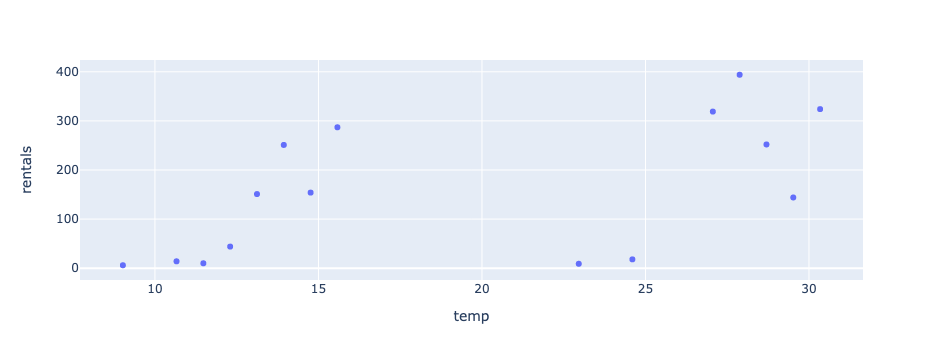

In [ ]:
px.scatter(df_temp_rentals, x="temp", y="rentals")

Spearman evtl. passender, da nichts über die Verteilung der Temperatur bekannt ist, bzw. die Art (linear/...) des möglichen Zusammenhangs

In [ ]:
pearsonr(df_temp_rentals["temp"], df_temp_rentals["rentals"])

(0.5508117587708542, 0.033340612842423664)

In [ ]:
spearmanr(df_temp_rentals["temp"], df_temp_rentals["rentals"])

SpearmanrResult(correlation=0.6535714285714285, pvalue=0.008230371463638973)

-> Korrelation mit 0.65 nicht so stark da, p-Wert von 0.08 -> nicht signifikant

-> Test der Temperatur auf Normalverteilung?

# 5. Evaluation